# CDE2 - Smart Classroom Challenge
##### Flavio Studer, Gregor Hammer, Jan Zumwald

In [1]:
# Pakete Laden
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy import interpolate
from scipy.stats import linregress
import seaborn as sns
from scipy import stats
import pingouin as pg

### Datenexploration und -transformation
#### Die Datensätze werden geladen, exploriert und transformiert, bevor diese zur Beantwortung der Fragestellungen verwendet werden.

In [2]:
# Externe Daten von Möhlin und Freiburg importieren
folder_path_m = "Daten_Möhlin_01.04.2023-09.05.2023"
filename_m = "Möhlin_Lufttemperatur_111513_MOE_tre200s0_1_data.txt"
file_path_m = folder_path_m + "/" + filename_m

folder_path_f = "Daten_Freiburg_09.05.2023-02.06.2023"
filename_f = "Freiburg_Lufttemperatur_GRA_tre200s0_1_data.txt"
file_path_f = folder_path_f + "/" + filename_f


# Funktion für Daten einlesen, Datentypen ändern und umformatieren
def process_external_data(file_path):
    # Daten aus CSV-Datei einlesen
    data = pd.read_csv(file_path, delimiter=";")

    # Uhrzeitspalte splitten
    data["time"] = data["time"].astype(str)
    data["Jahr"] = data["time"].str[:4]
    data["Monat"] = data["time"].str[4:6]
    data["Tag"] = data["time"].str[6:8]
    data["Stunde"] = data["time"].str[8:10]
    data["Minute"] = data["time"].str[10:12]

    # Datum und Uhrzeit kombinieren und in einer Spalte speichern
    data["Zeitpunkt"] = pd.to_datetime(data["Jahr"] + "-" + data["Monat"] + "-" + data["Tag"] + " " + data["Stunde"] + ":" + data["Minute"], format="%Y-%m-%d %H:%M")

    # Spalten auswählen und umbenennen
    data = data.loc[:, ["stn", "Zeitpunkt", "tre200s0"]]
    data.rename(columns={"stn": "Standort", "tre200s0": "Lufttemperatur"}, inplace=True)

    return data

# data_m für Möhlin und data_f für Freiburg erstellen
data_m = process_external_data(file_path_m)
data_f = process_external_data(file_path_f)

# Daten Filtern, da Erhebung mit Sensor erst ab 27.04.2023
data_m = data_m[data_m['Zeitpunkt'] >= pd.to_datetime('2023-04-27')]

# Beispiel: Ausgabe der ersten Zeilen der DataFrames
print(data_m.head(5))
print(data_f.head(5))

     Standort           Zeitpunkt  Lufttemperatur
3744      MOE 2023-04-27 00:00:00             8.5
3745      MOE 2023-04-27 00:10:00             8.7
3746      MOE 2023-04-27 00:20:00             8.8
3747      MOE 2023-04-27 00:30:00             8.9
3748      MOE 2023-04-27 00:40:00             8.9
  Standort           Zeitpunkt  Lufttemperatur
0      GRA 2023-05-09 00:00:00            10.8
1      GRA 2023-05-09 00:10:00            10.8
2      GRA 2023-05-09 00:20:00            10.4
3      GRA 2023-05-09 00:30:00            10.1
4      GRA 2023-05-09 00:40:00            10.2


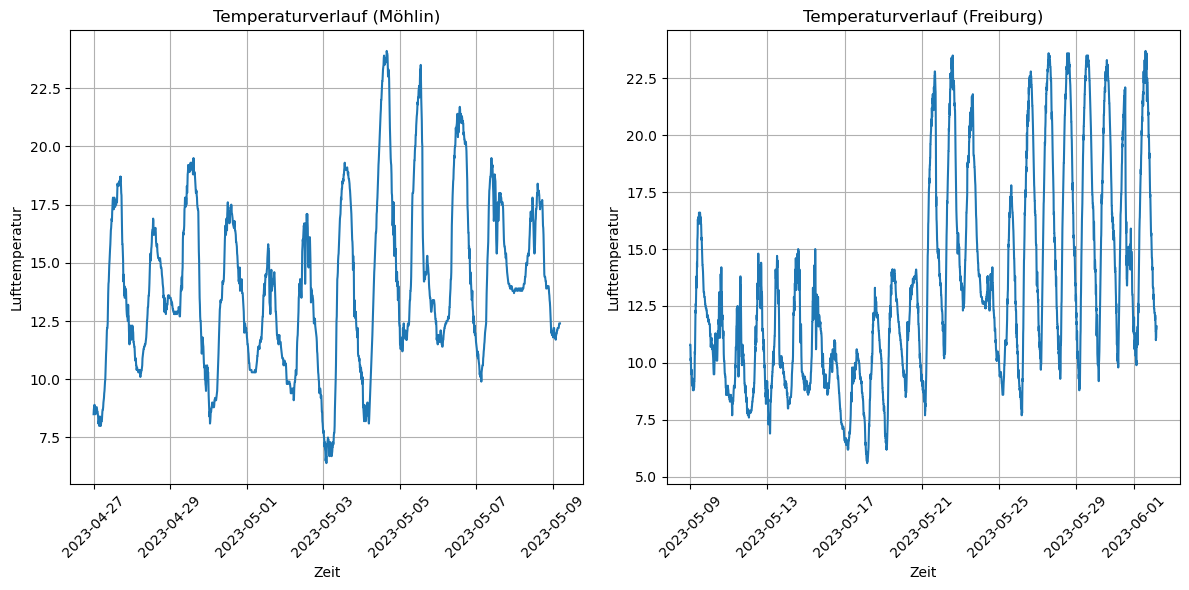

In [3]:
# Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Temperaturverlauf für data_m (Möhlin)
ax1.plot(data_m["Zeitpunkt"], data_m["Lufttemperatur"])
ax1.set_xlabel("Zeit")
ax1.set_ylabel("Lufttemperatur")
ax1.set_title("Temperaturverlauf (Möhlin)")
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)  # X-Achse um 45 Grad drehen

# Temperaturverlauf für data_f (Freiburg)
ax2.plot(data_f["Zeitpunkt"], data_f["Lufttemperatur"])
ax2.set_xlabel("Zeit")
ax2.set_ylabel("Lufttemperatur")
ax2.set_title("Temperaturverlauf (Freiburg)")
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)  # X-Achse um 45 Grad drehen

# Layout anpassen
plt.tight_layout()

# Plot anzeigen
plt.show()


Die externen Daten von Freiburg wurden über einen grösseren Zeitraum als die von Möhlin exportiert. Dies aus dem Grund, weil in Freiburg in 2 verschiedenen Räumen gemessen wurde und dies über eine längere Periode dauerte.

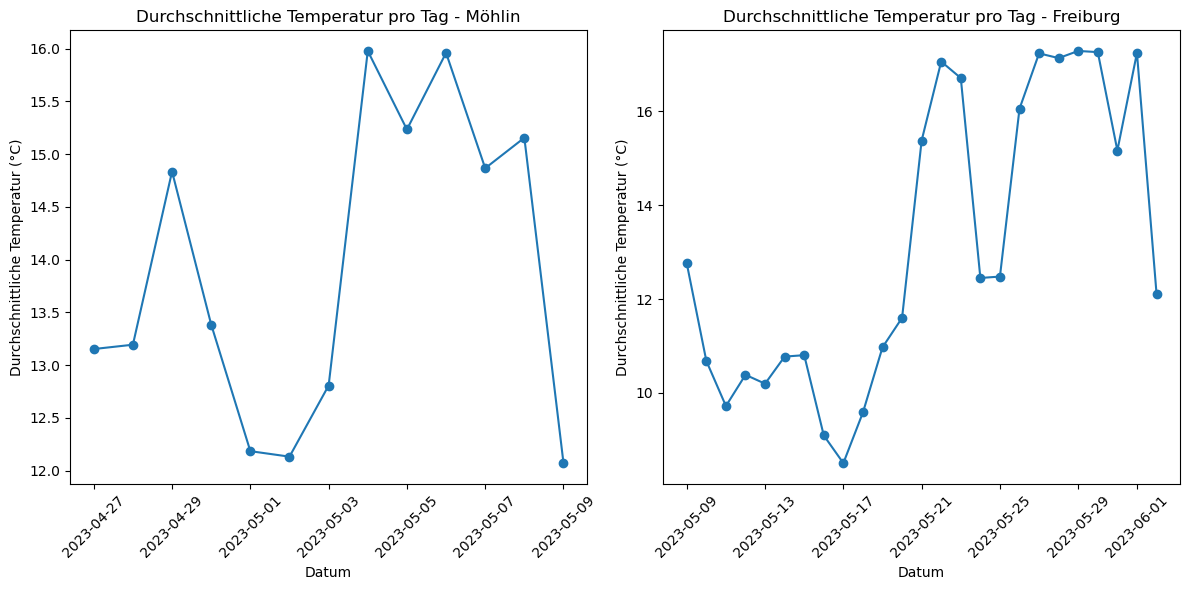

In [4]:
# Extrahiere Datum aus Zeitpunkt für data_m
data_m['Datum'] = data_m['Zeitpunkt'].dt.date

# Berechne den Durchschnitt der Lufttemperatur pro Tag für data_m
daily_average_m = data_m.groupby('Datum')['Lufttemperatur'].mean()

# Extrahiere Datum aus Zeitpunkt für data_f
data_f['Datum'] = data_f['Zeitpunkt'].dt.date

# Berechne den Durchschnitt der Lufttemperatur pro Tag für data_f
daily_average_f = data_f.groupby('Datum')['Lufttemperatur'].mean()

# Erstelle den Subplot mit zwei Plots nebeneinander
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot für data_m
ax1.plot(daily_average_m.index, daily_average_m.values, marker='o')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Durchschnittliche Temperatur (°C)')
ax1.set_title('Durchschnittliche Temperatur pro Tag - Möhlin')
ax1.tick_params(axis='x', rotation=45)

# Plot für data_f
ax2.plot(daily_average_f.index, daily_average_f.values, marker='o')
ax2.set_xlabel('Datum')
ax2.set_ylabel('Durchschnittliche Temperatur (°C)')
ax2.set_title('Durchschnittliche Temperatur pro Tag - Freiburg')
ax2.tick_params(axis='x', rotation=45)

# Automatische Anpassung der Subplots
plt.tight_layout()

# Zeige den Plot an
plt.show()

Durch das Mitteln der Tagestemperaturen wurde ersichtlich, dass sich diese über die einzelnen Zeitperioden verändert haben. Dies ist wichtig, um eine Grundlage für die erste Fragestellung zu schaffen.

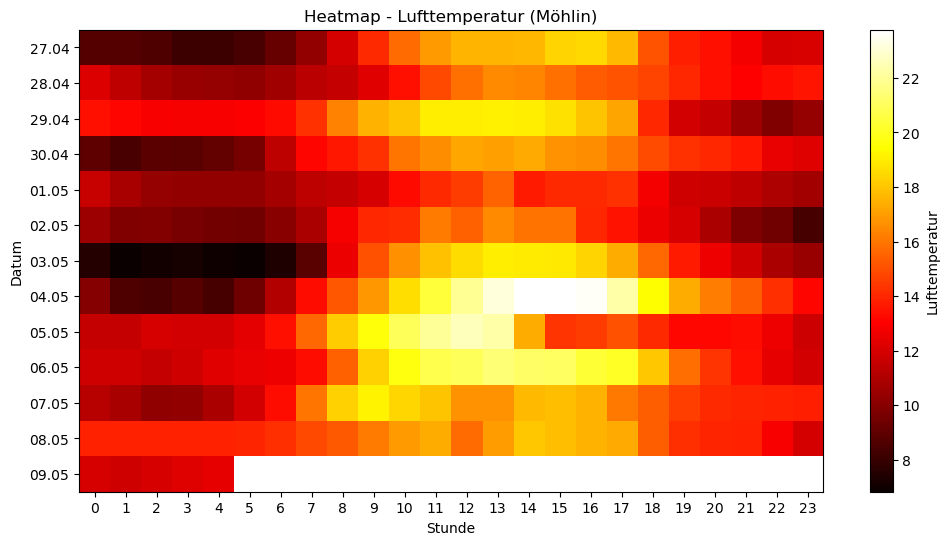

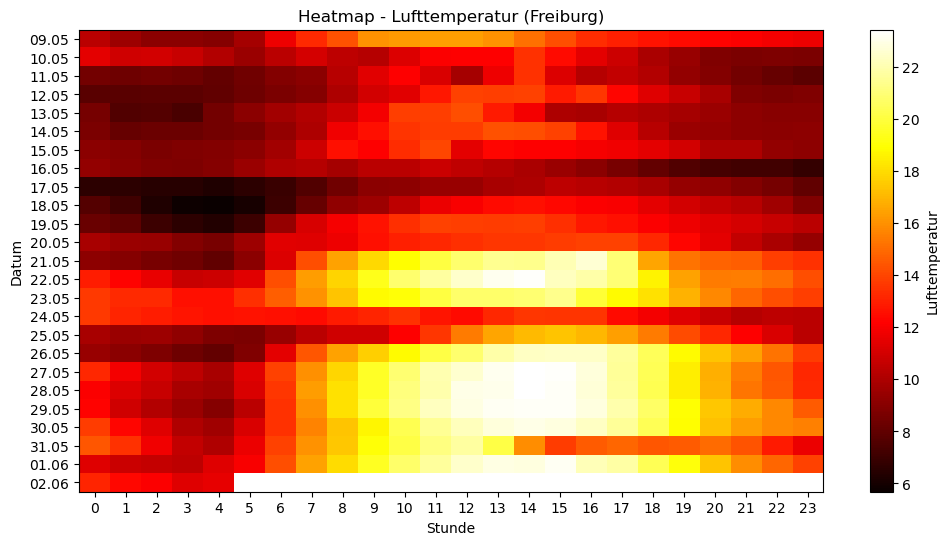

In [5]:
# Erstelle ein neues DataFrame mit Tagen als Index und Stunden als Spalten für data_m
heatmap_data_m = data_m.pivot_table(index=data_m["Zeitpunkt"].dt.date, columns=data_m["Zeitpunkt"].dt.hour, values="Lufttemperatur")

# Erstelle ein neues DataFrame mit Tagen als Index und Stunden als Spalten für data_f
heatmap_data_f = data_f.pivot_table(index=data_f["Zeitpunkt"].dt.date, columns=data_f["Zeitpunkt"].dt.hour, values="Lufttemperatur")

# Heatmap der Lufttemperatur für data_m
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_data_m, cmap="hot", aspect="auto")
plt.colorbar(label="Lufttemperatur")
plt.xlabel("Stunde")
plt.ylabel("Datum")

# Formatierung der x- und y-Achsen für data_m
plt.xticks(range(len(heatmap_data_m.columns)), heatmap_data_m.columns)
plt.yticks(range(len(heatmap_data_m.index)), [date.strftime("%d.%m") for date in heatmap_data_m.index])

plt.title("Heatmap - Lufttemperatur (Möhlin)")
plt.show()

# Heatmap der Lufttemperatur für data_f
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_data_f, cmap="hot", aspect="auto")
plt.colorbar(label="Lufttemperatur")
plt.xlabel("Stunde")
plt.ylabel("Datum")

# Formatierung der x- und y-Achsen für data_f
plt.xticks(range(len(heatmap_data_f.columns)), heatmap_data_f.columns)
plt.yticks(range(len(heatmap_data_f.index)), [date.strftime("%d.%m") for date in heatmap_data_f.index])

plt.title("Heatmap - Lufttemperatur (Freiburg)")
plt.show()


Mit der Heatmap werden die Erkenntnisse aus dem Lineplot bestätigt. Es gab in Möhlin sowie in Freiburg grössere Temperaturschwankungen.

In [27]:
# Laden der erhobenen Daten von Sensor
data2 = pd.read_csv("Sensordaten/05_06_2023Data.csv", delimiter=",", encoding="latin-1")
data2["MEASUREMENT_TIME"] = pd.to_datetime(data2["MEASUREMENT_TIME"])
data2 = data2.sort_values(by="MEASUREMENT_TIME")

# Initialisiere Variablen
prev_window = None
prev_location = None
sequence_num = 1
sequences = []

# Iteriere über die Zeilen des DataFrames
for index, row in data2.iterrows():
    # Überprüfe den Fensterstatus und die Location-ID
    window = row['WINDOW_OPEN']
    location = row['LOCATION_ID']
    
    # Überprüfe, ob eine neue Sequenz beginnen soll
    if prev_window is None or prev_window != window or prev_location != location:
        # Bestimme den Sequenzbezeichner
        if window == 1:
            sequence_label = 'O'
        else:
            sequence_label = 'G'
        
        # Setze die Sequenzbezeichnung
        sequence = f"{sequence_label}_{location}_{sequence_num}"
        sequences.append(sequence)
        sequence_num += 1
    else:
        # Verwende die vorherige Sequenzbezeichnung
        sequences.append(sequence)
    
    # Aktualisiere die vorherigen Werte für den nächsten Durchlauf
    prev_window = window
    prev_location = location

# Füge die Sequenzen dem DataFrame hinzu
data2['Sequenz'] = sequences

# Initialisiere eine neue Spalte für die zeitliche Differenz
data2['Zeitdifferenz'] = 0

# Iteriere über die eindeutigen Sequenzen
for seq in data2['Sequenz'].unique():
    # Filtere den DataFrame für die aktuelle Sequenz
    seq_data = data2[data2['Sequenz'] == seq]
    
    # Berechne die zeitliche Differenz ab dem ersten Datenpunkt
    seq_data['Zeitdifferenz'] = (seq_data['MEASUREMENT_TIME'] - seq_data.iloc[0]['MEASUREMENT_TIME']).dt.total_seconds()
    
    # Aktualisiere die Werte in der ursprünglichen DataFrame
    data2.loc[data2['Sequenz'] == seq, 'Zeitdifferenz'] = seq_data['Zeitdifferenz']

C:\Users\janzu\AppData\Local\Temp\ipykernel_62608\3606127649.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq_data['Zeitdifferenz'] = (seq_data['MEASUREMENT_TIME'] - seq_data.iloc[0]['MEASUREMENT_TIME']).dt.total_seconds()


In [7]:
# Beispiel für transformierte Daten
print(data2.tail(5))

            ID                  UPLOAD_TIME    MEASUREMENT_TIME  LOCATION_ID  \
294753  304450  05.06.23 07:18:59.370443000 2023-06-05 09:18:58            5   
294754  304451  05.06.23 07:19:09.365325000 2023-06-05 09:19:08            5   
294598  304452  05.06.23 07:19:19.487778000 2023-06-05 09:19:18            5   
303135  304453  05.06.23 07:19:31.344602000 2023-06-05 09:19:30            5   
302991  304454  05.06.23 07:19:41.377297000 2023-06-05 09:19:40            5   

        WINDOW_OPEN  TEMPERATURE_VALUE TEMPERATURE_UNIT  HUMIDITY_VALUE  \
294753            0              25.73               °C           49.46   
294754            0              25.73               °C           49.46   
294598            0              25.73               °C           49.48   
303135            0              25.75               °C           49.46   
302991            0              25.75               °C           49.50   

       HUMIDITY_UNIT  CO2_VALUE CO2_UNIT  Sequenz  Zeitdifferenz  
2

In den Fragestellungen soll grundsätzlich der Anstieg und das Abfallen des CO2-Wertes untersucht werden. Um hierfür vergleichbare Daten zu schaffen, wurden bei jedem Statuswechsel des Fensters und jedem Wechsel des Erhebungsortes, in einer neuen Spalte eine Sequenz zugeordnet. In der Sequenznummerierung ist ersichtlich, ob das Fenster offen (O) oder geschlossen (G) ist, um welchen Erhebungsort es sich handelt sowie die Indexierung.

Beispiel G_5_240:
- G: Geschlossen
- 5: Erhebungsort 5
- 240: Index dieser Sequenz

In der Spalte Zeitdifferenz wird angegeben, wie viel Zeit in Sekunden vergangen ist, seit die jeweilige Sequenz gestartet ist. Die Messungen sind in ca. 10 Sekunden Intervallen vorhanden.


In [8]:
# Dateneigenschaften anschauen
print(data2.describe())

# Maximalwert anzeigen
max_co2_row = data2.loc[data2['CO2_VALUE'].idxmax()]
print(max_co2_row)

                 ID    LOCATION_ID    WINDOW_OPEN  TEMPERATURE_VALUE  \
count  304115.00000  304115.000000  304115.000000      304115.000000   
mean   152350.54310       3.505121       0.117824          24.766098   
std     87813.49725       1.674475       0.322400           2.373282   
min       193.00000       0.000000       0.000000          12.070000   
25%     76317.50000       2.000000       0.000000          24.090000   
50%    152346.00000       5.000000       0.000000          24.910000   
75%    228397.50000       5.000000       0.000000          25.730000   
max    304454.00000       5.000000       1.000000          30.120000   

       HUMIDITY_VALUE      CO2_VALUE  Zeitdifferenz  
count   304115.000000  304115.000000  304115.000000  
mean        49.655002     723.124433   21940.369686  
std          7.346091     508.415788   22348.629445  
min         28.420000     223.750000       0.000000  
25%         46.200000     383.575000    5618.000000  
50%         51.430000     5

In der Zusammenfassung der Daten sind noch keine spezielle Auffälligkeiten ersichtlich. Ein überaus grosser CO2-Wert wurde festgestellt, dieser fand jedoch in der Location 0 statt, welche für Tests und Transport verwendet wird.

In [9]:
# Grössere Erhebungslücken in den selbst erhobenen Daten finden

# Sortiere den DataFrame nach der Spalte "MEASUREMENT_TIME"
df_sorted = data2.sort_values(by="MEASUREMENT_TIME")

# Setze den Index auf die "MEASUREMENT_TIME" Spalte für den Zugriff nach Datum
df_sorted.set_index("MEASUREMENT_TIME", inplace=True)

# Berechne die Zeitunterschiede zwischen aufeinanderfolgenden Datensätzen
time_diff = df_sorted.index.to_series().diff()

# Finde die Indizes der größeren Lücken (> 1 Stunde)
large_gaps_indices = time_diff[time_diff > pd.Timedelta(hours=1)].index

# Zeige die größeren Lücken an
for idx in large_gaps_indices:
    time_diff_hours = time_diff[idx] / pd.Timedelta(hours=1)
    print(f"Lücke zwischen {idx - time_diff[idx]} und {idx}: {time_diff_hours:.2f} Stunden")

Lücke zwischen 2023-05-13 23:58:04 und 2023-05-14 17:01:21: 17.05 Stunden
Lücke zwischen 2023-05-17 18:24:13 und 2023-05-17 20:29:21: 2.09 Stunden
Lücke zwischen 2023-05-24 10:49:08 und 2023-05-24 12:00:55: 1.20 Stunden


Damit die kontinuierliche Erhebung der Daten bestätigt werden kann, werden hier die Erhebungslücken, die über 1 Stunde dauerten, dargestellt. Bei der grossen Lücke von 17.05 Stunden handelt es sich um ein Programmfehler. Im total gibt es 3 Lücken, welche aber für die weiteren Untersuchungen nicht von grosser Bedeutung sind und kein Störfaktor darstellen sollten. Im Verhältnis zur Erhebungsdauer von 34 Tagen sind die Lücken zu verantworten.

In [10]:
# Separieren von Location 2 von data2 (Innenraum Gregor, 2 <- Schlafzimmer)
data2_loc2 = data2[data2['LOCATION_ID'] == 2]

# Separieren von Location 3 und 5 data2 (Innenräume Jan, 3 <- Wohnzimmer, 5 <- Schlafzimmer)
data2_loc3_5 = data2[(data2['LOCATION_ID'] == 3) | (data2['LOCATION_ID'] == 5)]

# Funktion um Daten mit Aussentemperaturen zu mergen, NA's zu implementieren und Spaltennamen abzuändern
def merge_and_interpolate(data2_loc, data):
    # Setze einen Toleranzbereich für die Zeitunterschiede
    tolerance = pd.Timedelta(seconds=10)

    # Verbinde die Datensätze basierend auf den Zeitstempeln im Toleranzbereich
    merged_data = pd.merge_asof(data2_loc, data, left_on='MEASUREMENT_TIME', right_on='Zeitpunkt', tolerance=tolerance)

    # Externe Daten aufgrund zu großer Intervalle mit NAs ergänzen
    merged_data["Lufttemperatur"].interpolate(method="linear", inplace=True)

    # Umbenennung der Spalten
    merged_data = merged_data.rename(columns={
        'MEASUREMENT_TIME': 'Zeit',
        'LOCATION_ID': 'Erhebungsort',
        'WINDOW_OPEN': 'Fensterstatus',
        'TEMPERATURE_VALUE': 'Innentemperatur',
        'HUMIDITY_VALUE': 'Luftfeuchtigkeit',
        'CO2_VALUE': 'CO2-Wert',
        'Lufttemperatur': 'Aussentemperatur'
    })
    
    # Berechnung der Temperaturdifferenz
    merged_data['Temperaturdifferenz'] = merged_data['Innentemperatur'] - merged_data['Aussentemperatur']

    # Auswahl der gewünschten Spalten
    selected_columns = ['Zeit', 'Erhebungsort', 'Fensterstatus', 'Innentemperatur', 'Luftfeuchtigkeit', 'CO2-Wert', 'Aussentemperatur', 'Sequenz', 'Zeitdifferenz', 'Temperaturdifferenz']
    data2_loc_merged = merged_data[selected_columns]

    return data2_loc_merged

# Finale Datensets für weitere Analysen erstellen
data2_loc2 = merge_and_interpolate(data2_loc2, data_m)
data2_loc3_5 = merge_and_interpolate(data2_loc3_5, data_f)
data2_loc3 = data2_loc3_5[data2_loc3_5['Erhebungsort'] == 3]
data2_loc5 = data2_loc3_5[data2_loc3_5['Erhebungsort'] == 5]
data2_loc5 = data2_loc5[(data2_loc5['Zeit'] >= pd.to_datetime('2023-05-16')) & (data2_loc5['Zeit'] <= pd.to_datetime('2023-06-01'))]

Nach der Aufteilung der Daten in zwei Perioden werdend diese mit den externen Daten nach der Zeit-Variable zusammengeführt. Da die Zeitintervalle der externen Daten 10 Minuten betragen, stimmten diese nicht überein. Mithilfe der Interpolate-Funktion von Scipy, konnten die Daten implementiert werden. Anschliessend wurde die Spalte "Temperaturdifferenz" hinzugefügt, welche die Differenz zwischen Innen- und Aussentemperatur festhält.

Für die weitere Verarbeitung wurden im Datensatz anschliessend die Spalten umbenannt und selektiert sowie nach den Erhebungsorten separiert.

In [11]:
datasets = {
    "Erhebungsort 2": data2_loc2,
    "Erhebungsort 3": data2_loc3,
    "Erhebungsort 5": data2_loc5
}

for location, dataset in datasets.items():
    # Hinzufügen eines Kommentars für die Location
    print(f"Zusammenfassung für Dataset {location}:")
    
    # Erstellen der Zusammenfassung
    summary = dataset.describe()
    
    # Ausgabe der Zusammenfassung
    print(summary)
    print("------------------------")

Zusammenfassung für Dataset Erhebungsort 2:
       Erhebungsort  Fensterstatus  Innentemperatur  Luftfeuchtigkeit  \
count       50326.0   50326.000000     50326.000000      50326.000000   
mean            2.0       0.259409        27.206518         39.029849   
std             0.0       0.438315         1.623676          3.942754   
min             2.0       0.000000        19.050000         32.880000   
25%             2.0       0.000000        26.610000         36.970000   
50%             2.0       0.000000        27.530000         37.790000   
75%             2.0       1.000000        28.280000         39.980000   
max             2.0       1.000000        29.870000         64.110000   

           CO2-Wert  Aussentemperatur  Zeitdifferenz  Temperaturdifferenz  
count  50326.000000      50301.000000   50326.000000         50301.000000  
mean     497.607472         14.012681   18340.830565            13.194704  
std      194.151017          3.468063   21954.473434             3.491

Für die Beantwortung der Fragestellungen verbleiben somit die drei Datensets
- data2_loc2: Erhebungsort 2 - Schlaf-/Arbeitszimmer Möhlin
- data2_loc3: Erhebungsort 3 - Wohn-/Arbeitszimmer Freiburg
- data2_loc5: Erhebungsort 5 - Schlafzimmer Freiburg

mit den Variablen
- Zeit
- Erhebungsort
- Fensterstatus
    - 1 für offen, 0 für geschlossen
- Innentemperatur
    - in Grad Celsius
- Luftfeuchtigkeit
    - relativ in %
- CO2-Wert
    - in ppm
- Aussentemperatur
    - in Grad Celsius
- Sequenz
- Zeitdifferenz
    - in Sekunden
- Temperaturdifferenz
    - in Grad Celsius

### Fragestellung 1
### Welchen Einfluss hat der Unterschied zwischen Aussen- und Innentemperatur beim Lüften auf die Senkung des CO2-Wertes?
#### Hypothese: Die Temperaturdifferenz trägt beim Lüften nur wenig bei zur Senkung des CO2-Wertes.

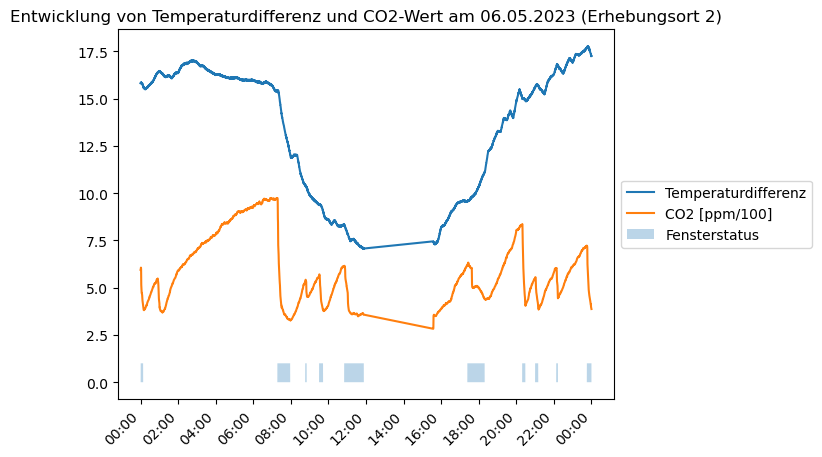

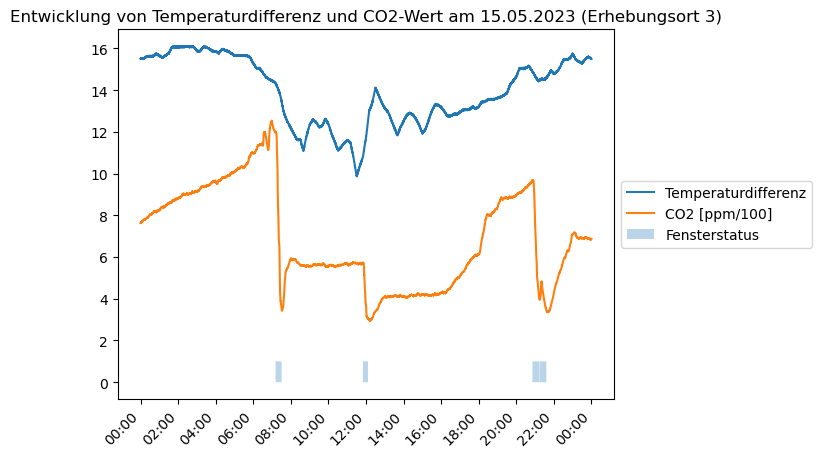

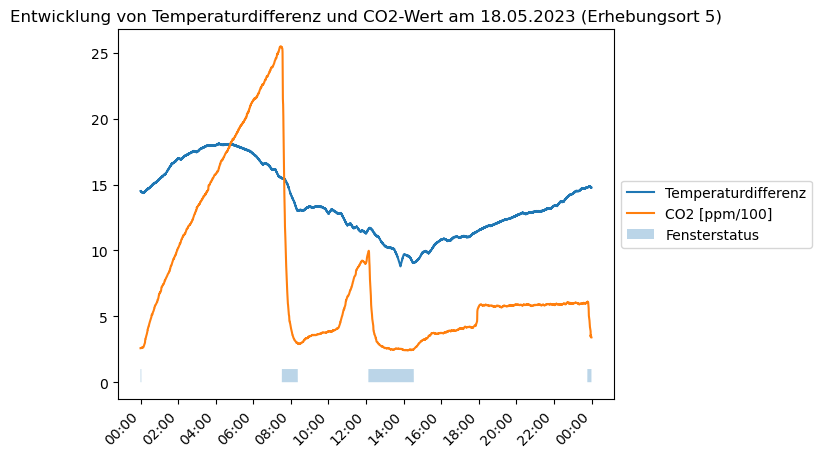

In [12]:
# Funktion für Plot, welcher Verlauf von Temperturdifferenz, CO2-Wert und Fensterstatus
def plot_temperature_development(data, date):
    # Filtere nach dem angegebenen Datum
    data_filtered = data[data['Zeit'].dt.date == date.date()]

    # Lineplot für die Temperaturdifferenz
    plt.plot(data_filtered['Zeit'], data_filtered['Temperaturdifferenz'], label='Temperaturdifferenz')

    # Lineplot für den CO2-Wert (nach der Division durch 100)
    plt.plot(data_filtered['Zeit'], data_filtered['CO2-Wert'] / 100, label='CO2 [ppm/100]')

    # Plot für das Fensterstatus
    if 'Fensterstatus' in data.columns:
        window_open = data_filtered['Fensterstatus']
        plt.fill_between(data_filtered['Zeit'], 0, window_open, alpha=0.3, label='Fensterstatus')

    # Formatierung der x-Achse mit vernünftigen Intervallen
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Legende für die Farben (rechts)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Setze den Titel mit dem Erhebungsort
    erhebungsort = data['Erhebungsort'].iloc[0]
    plt.title(f'Entwicklung von Temperaturdifferenz und CO2-Wert am {date.strftime("%d.%m.%Y")} (Erhebungsort {erhebungsort})')

    # Zeige den Plot an
    plt.show()

plot_temperature_development(data2_loc2, pd.to_datetime('2023-05-06'))
plot_temperature_development(data2_loc3, pd.to_datetime('2023-05-15'))
plot_temperature_development(data2_loc5, pd.to_datetime('2023-05-18'))

Bei der Tagesübersicht wird die Temperaturdifferenz zusammen mit dem CO2-Wert (geteilt durch 100) in Abhängigkeit mit dem Fensterstatus (Blau wenn offen) dargestellt. Hier können bereits Tendenzen erkannt werden aber noch keine genauen Muster.

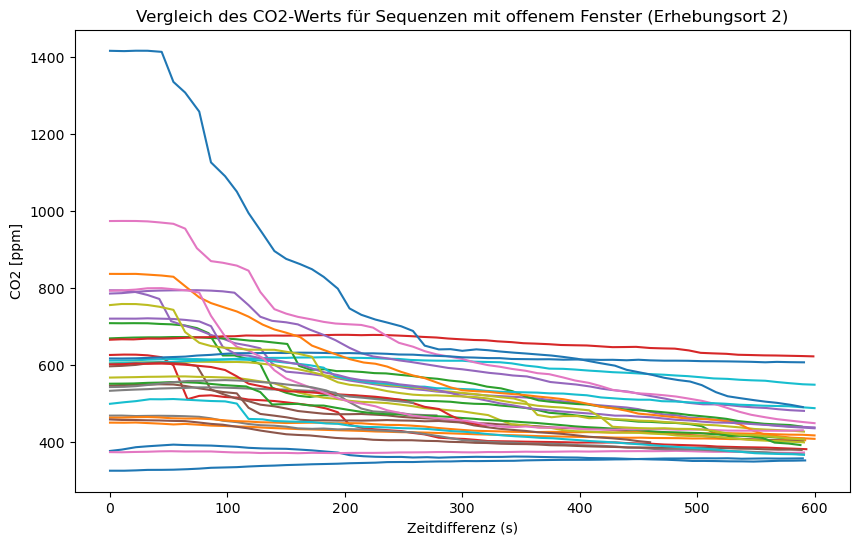

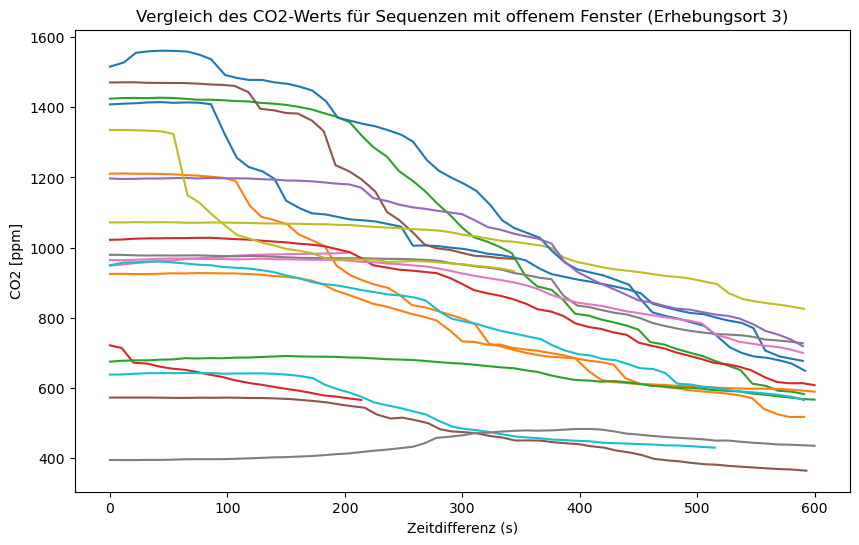

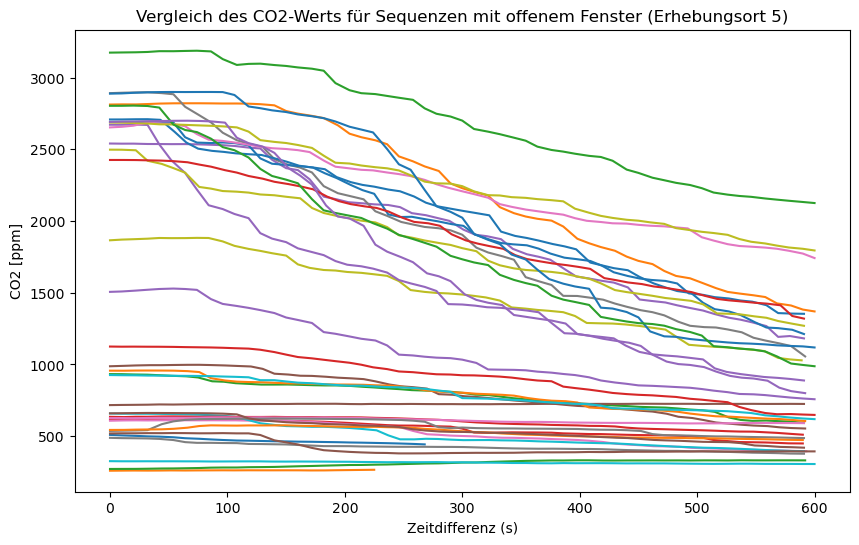

In [13]:
def plot_sequences(data, zeitdifferenz, fensterstatus):
    # Extrahiere die eindeutigen Sequenzen mit offenem Fenster (Sequenz beginnend mit "O")
    window_sequences = data[data['Sequenz'].str.startswith(fensterstatus)]
    unique_sequences = window_sequences['Sequenz'].unique()

    # Plot für die eindeutigen Sequenzen mit offenem Fenster
    plt.figure(figsize=(10, 6))
    for sequence in unique_sequences:
        sequence_data = window_sequences[window_sequences['Sequenz'] == sequence]

        # Begrenze die Zeitdifferenz auf den angegebenen Wert
        sequence_data = sequence_data[sequence_data['Zeitdifferenz'] <= zeitdifferenz]

        # Zeitdifferenz auf der x-Achse verwenden
        x_values = sequence_data['Zeitdifferenz']

        plt.plot(x_values, sequence_data['CO2-Wert'], label=sequence)

    plt.xlabel('Zeitdifferenz (s)')
    plt.ylabel('CO2 [ppm]')
    
    # Wähle den passenden Titel basierend auf dem fensterstatus
    erhebungsort = data['Erhebungsort'].iloc[0]
    if fensterstatus == 'O':
        plt.title(f'Vergleich des CO2-Werts für Sequenzen mit offenem Fenster (Erhebungsort {erhebungsort})')
    elif fensterstatus == 'G':
        plt.title(f'Vergleich des CO2-Werts für Sequenzen mit geschlossenem Fenster (Erhebungsort {erhebungsort})')

    plt.show()


plot_sequences(data2_loc2, 600, 'O')
plot_sequences(data2_loc3, 600, 'O')
plot_sequences(data2_loc5, 600, 'O')
    


Hier ist pro Erhebungsort ersichtlich, wie sich der CO2-Wert nach dem öffnen des Fensters innert 10 Minuten entwickelte. In den tieferen Bereichen glichen sich diese mit der Zeit aus. Über diese Linien werden anschliessend mithilfe Linearer Regression eine Gerade darübergelegt, aus welcher eine Steigung entnommen werden kann und somit die Änderungsrate in ppm pro Sekunde als Vergleichszahl verfügbar ist.

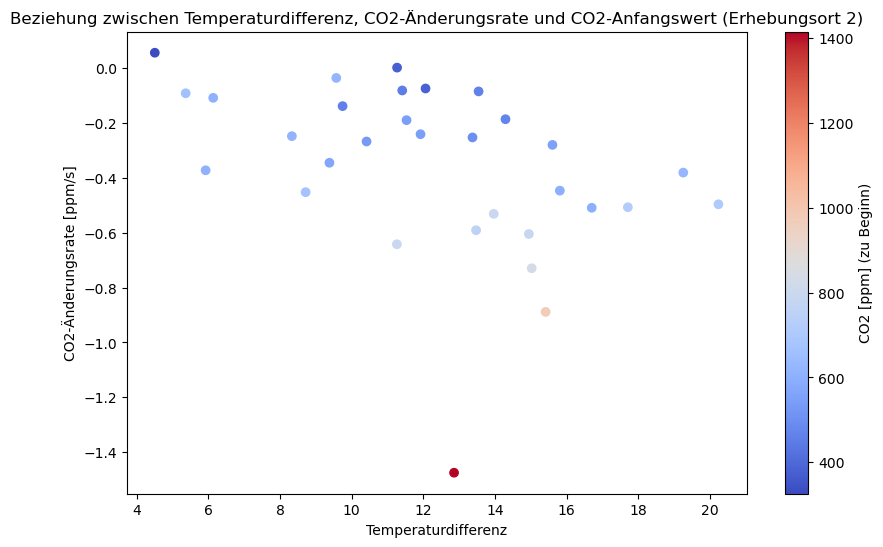

Partielle Korrelation:
          n         r           CI95%     p-val
pearson  31 -0.503915  [-0.73, -0.18]  0.004524


C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


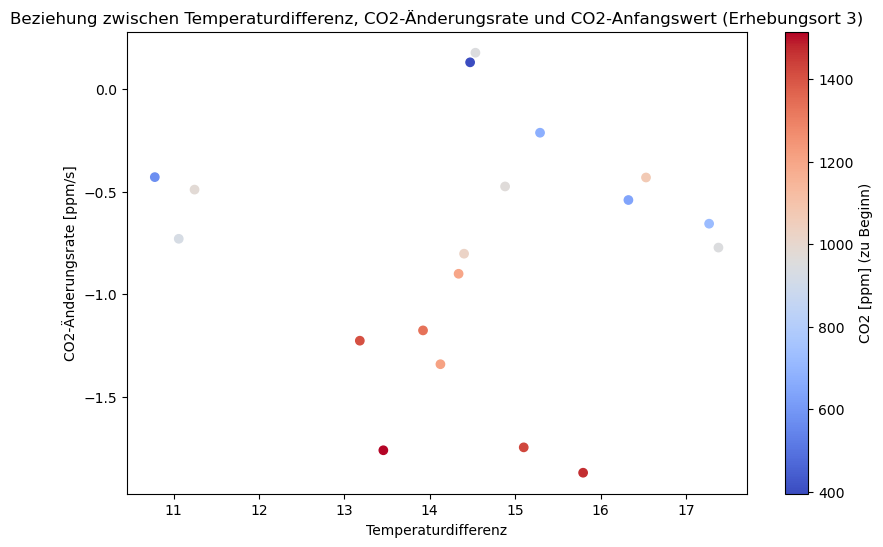

Partielle Korrelation:
          n         r          CI95%     p-val
pearson  19 -0.062933  [-0.51, 0.42]  0.804072


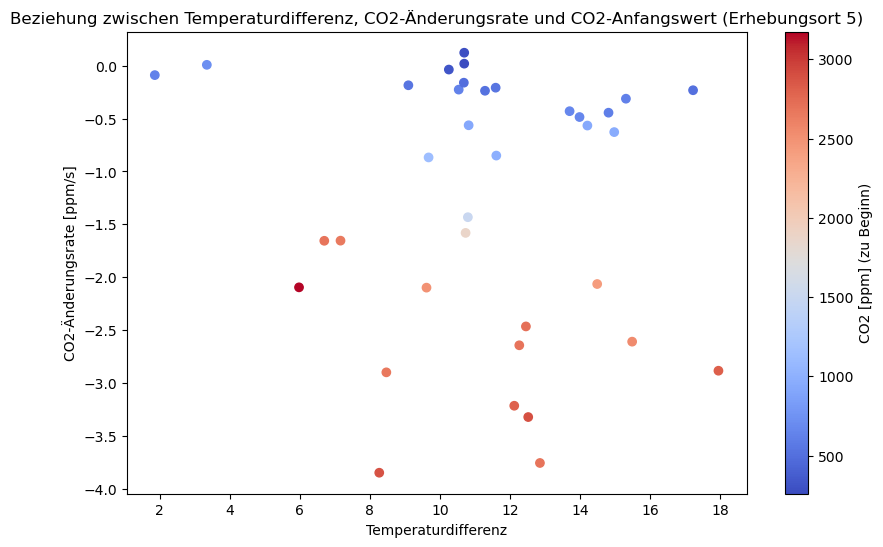

Partielle Korrelation:
          n         r           CI95%     p-val
pearson  36 -0.390747  [-0.64, -0.07]  0.020294


In [14]:
def plot_regression_scatter(data):
    # Filtere den DataFrame für Sequenzen mit offenem Fenster und Zeitdifferenz bis 600
    filtered_data = data[(data['Fensterstatus'] == 1) & (data['Zeitdifferenz'] <= 600)]
    erhebungsort = data['Erhebungsort'].iloc[0]

    # Gruppiere nach Sequenz und berechne Lineare Regression für jede Sequenz
    grouped_data = filtered_data.groupby('Sequenz').apply(lambda x: linregress(x['Zeitdifferenz'], x['CO2-Wert']))

    # Extrahiere die Steigung der Linearen Regression und füge sie zum gruppierten Datensatz hinzu
    grouped_data = grouped_data.apply(lambda x: x.slope)
    grouped_data = grouped_data.to_frame(name='Steigung')

    # Füge die Temperaturdifferenz und den CO2-Wert zu Beginn der Sequenz hinzu
    start_values = filtered_data.groupby('Sequenz').agg({
        'Temperaturdifferenz': 'first',
        'CO2-Wert': 'first'
    })
    grouped_data = grouped_data.join(start_values, on='Sequenz')

    # Benenne die Spalten um
    grouped_data.columns = ['Steigung', 'Temperaturdifferenz', 'CO2-Wert (Anfang)']

    # Setze den Index zurück
    grouped_data.reset_index(inplace=True)

    # Extrahiere die benötigten Spalten aus grouped_data
    temperatur_diff = grouped_data['Temperaturdifferenz']
    co2_anfang = grouped_data['CO2-Wert (Anfang)']
    steigung = grouped_data['Steigung']

    # Erstelle den Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperatur_diff, steigung, c=co2_anfang, cmap='coolwarm')
    plt.colorbar(label='CO2 [ppm] (zu Beginn)')
    plt.xlabel('Temperaturdifferenz')
    plt.ylabel('CO2-Änderungsrate [ppm/s]')
    plt.title(f'Beziehung zwischen Temperaturdifferenz, CO2-Änderungsrate und CO2-Anfangswert (Erhebungsort {erhebungsort})')

    # Zeige den Plot an
    plt.show()
    
    # Berechnung der partiellen Korrelation
    partial_corr = pg.partial_corr(data=grouped_data, x='Temperaturdifferenz', y='Steigung', covar='CO2-Wert (Anfang)')

    # Ausgabe der Korrelationen
    print('Partielle Korrelation:')
    print(partial_corr)
    
plot_regression_scatter(data2_loc2)
plot_regression_scatter(data2_loc3)
plot_regression_scatter(data2_loc5)

Hier wird pro Erhebungsort jede zuvor ersichtliche Entwicklung des CO2-Wertes als Punkt dargestellt. Dafür wird die Steigung der zuvor erwähnten Geraden (Richtwert zum Abfallen des CO2-Wertes) der Temperaturdifferenz gegenübergestellt. Dabei wurde erkannt, dass der CO2-Anfangswert beim lüften grossen Einfluss hat auf das Abfallen des Wertes. Hierfür wurde die partielle Korrelation berechnet, welche die Korrelation zwischen Temperaturdifferenz und CO2-Änderungsrate errechnet und die Variable des CO2-Anfangswertes dabei ausschliesst.

Dies ergibt die folgenden Korrelationen:
- Erhebungsort 2: -0.503915 (mittelstarker negativer linearer Zusammenhang)
- Erhebungsort 3: -0.062933 (schwacher negativer linearer Zusammenhang)
- Erhebungsort 5: -0.390747 (mittelstarker negativer linearer Zusammenhang)

Bei den Erhebungsorten 2 und 5 handelt es sich um kleinere Räume, was der Grund hinter den unterschiedlichen Korrelationen im Vergleich mit Erhebungsort 3 sein könnte. Beim Erhebungsort 3 handelt es sich um ein Wohnzimmer, wo viele weitere Faktoren mitspielen, was hier Einfluss auf das Ergebnis haben könnte.

Somit ist die Hypothese, dass die Temperaturdifferenz beim Lüften nur wenig zur Senkung des CO2-Wertes beiträgt, wohl korrekt, doch es liegt eine mittlere Korrelation vor zwischen den beiden Variablen. 

### Fragestellung 2
### Haben Pflanzen in der Nacht einen merkbaren Einfluss auf den CO2-Anstieg?
#### Hypothese: Die Anwesenheit von Pflanzen bewirkt in der Nacht keine Veränderung des CO2-Anstieges.

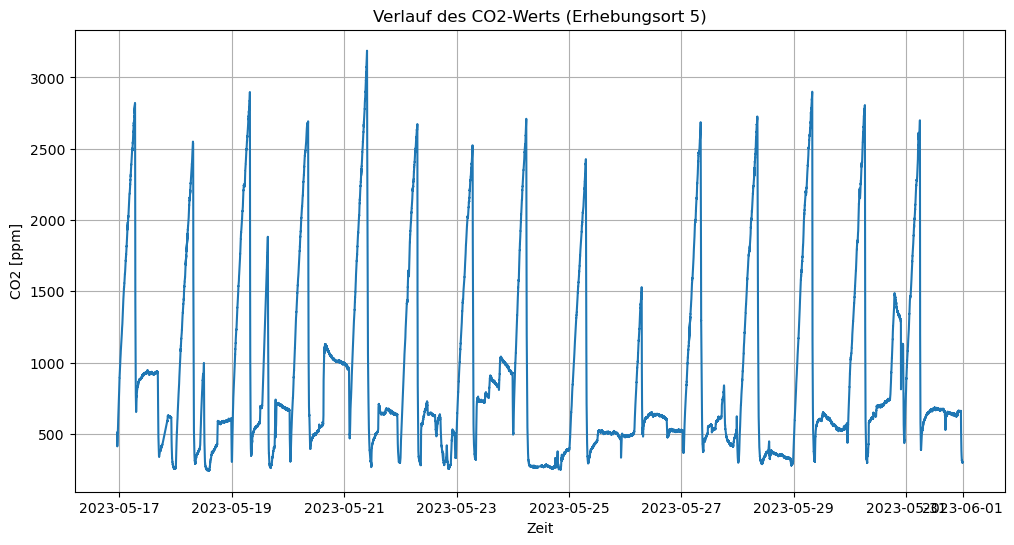

In [15]:
# Plotten des CO2-Werts über die Zeit
plt.figure(figsize=(12, 6))
plt.plot(data2_loc5["Zeit"], data2_loc5["CO2-Wert"])
plt.xlabel("Zeit")
plt.ylabel("CO2 [ppm]")
plt.title("Verlauf des CO2-Werts (Erhebungsort 5)")
plt.grid(True)
plt.show()

Es ist ersichtlich, dass beim Erhebungsort 5 die Werte in der Nacht jeweils Stark ansteigen.

In [16]:
# Gruppieren des Dataframes nach der Sequenz und Hinzufügen der neuen Spalte 'CO2_Differenz'
data2_loc5['CO2_Differenz'] = data2_loc5.groupby('Sequenz')['CO2-Wert'].diff()

# Auswählen der ersten Zeile für jede Sequenz und Extrahieren des CO2-Werts zu Beginn der Sequenz
erste_werte = data2_loc5.groupby('Sequenz')['CO2-Wert'].first().reset_index()
erste_werte = erste_werte.rename(columns={'CO2-Wert': 'CO2_Wert_Beginn'})

# Zusammenführen der ersten Werte mit dem ursprünglichen DataFrame basierend auf der Sequenz
data2_loc5 = pd.merge(data2_loc5, erste_werte, on='Sequenz')

# Berechnung der Differenz zwischen dem aktuellen CO2-Wert und dem CO2-Wert zu Beginn der Sequenz
data2_loc5['CO2_Wert_Differenz'] = data2_loc5['CO2-Wert'] - data2_loc5['CO2_Wert_Beginn']

data2_loc5 = data2_loc5.drop(['CO2_Differenz', 'CO2_Wert_Beginn'], axis=1)

# Festlegen des gewünschten Zeitraums
startzeit = pd.to_datetime('2023-05-19 18:00:00')
endzeit = pd.to_datetime('2023-05-25 15:00:00')

# Erstellen der Spalte "Pflanzen" basierend auf dem Zeitraum
data2_loc5['Pflanzen'] = (data2_loc5['Zeit'] >= startzeit) & (data2_loc5['Zeit'] < endzeit)

# Konvertieren der booleschen Werte in 0 und 1
data2_loc5['Pflanzen'] = data2_loc5['Pflanzen'].astype(int)

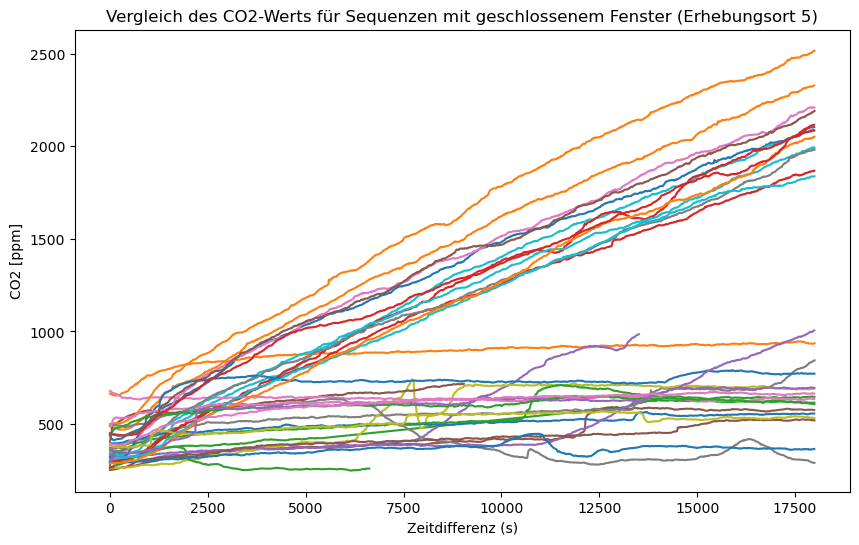

In [17]:
plot_sequences(data2_loc5, 18000, 'G')

Hier ist pro Erhebungsort wiederum ersichtlich, wie sich der CO2-Wert nach dem Schliessen des Fensters innert 5 Stunden entwickelte. Der Unterschied zwischen den steigenden und stagnierenden Werte ist, dass die steigenden in der Nacht waren und die Stagnierenden am Morgen, als gelüftet wurde und anschliessend das Haus verlassen.

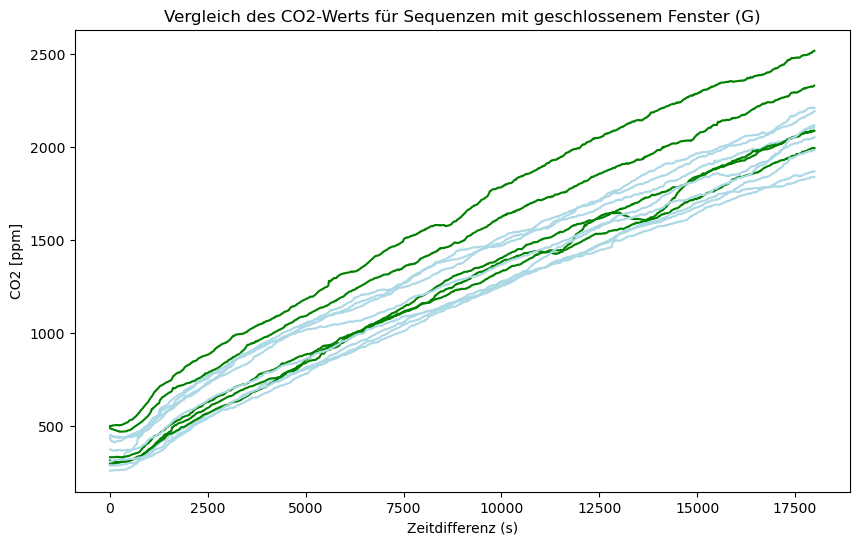

In [18]:
# Filtern der Sequenzen, die Werte über 1000 enthalten
filtered_sequences = data2_loc5[(data2_loc5['CO2-Wert'] > 1000) & (data2_loc5['Zeitdifferenz'] < 10000)]['Sequenz'].unique()

# Filtern des ursprünglichen Dataframes basierend auf den eindeutigen Sequenzen
filtered_data = data2_loc5[data2_loc5['Sequenz'].isin(filtered_sequences)]

def plot_sequences_plants(data, zeitdifferenz, fensterstatus):
    # Extrahiere die eindeutigen Sequenzen mit offenem Fenster (Sequenz beginnend mit "O")
    window_sequences = data[data['Sequenz'].str.startswith(fensterstatus)]
    unique_sequences = window_sequences['Sequenz'].unique()

    # Plot für die eindeutigen Sequenzen mit offenem Fenster
    plt.figure(figsize=(10, 6))
    for sequence in unique_sequences:
        sequence_data = window_sequences[window_sequences['Sequenz'] == sequence]

        # Begrenze die Zeitdifferenz auf den angegebenen Wert
        sequence_data = sequence_data[sequence_data['Zeitdifferenz'] <= zeitdifferenz]

        # Zeitdifferenz auf der x-Achse verwenden
        x_values = sequence_data['Zeitdifferenz']

        # Linienfarbe basierend auf der Spalte "Pflanzen"
        if sequence_data['Pflanzen'].iloc[0] == 1:
            line_color = 'green'
        else:
            line_color = 'lightblue'

        plt.plot(x_values, sequence_data['CO2-Wert'], label=sequence, color=line_color)

    plt.xlabel('Zeitdifferenz (s)')
    plt.ylabel('CO2 [ppm]')
    plt.title(f'Vergleich des CO2-Werts für Sequenzen mit geschlossenem Fenster ({fensterstatus})')
    plt.show()
    
plot_sequences_plants(filtered_data, 18000, 'G')

Nach dem extrahieren der nächtlichen Werte, wurden die Sequenzen erneut geplottet, diesmal mit grün wenn Pflanzen im Zimmer waren und mit blau wenn keine Pflanzen im Zimmer waren.

    Sequenz  Steigung  Pflanzen
0   G_5_146  0.091004         0
1   G_5_152  0.087540         0
2   G_5_158  0.097991         0
3   G_5_164  0.100359         1
4   G_5_168  0.102664         1
5   G_5_172  0.100186         1
6   G_5_184  0.089783         1
7   G_5_188  0.111874         1
8   G_5_200  0.086199         0
9   G_5_204  0.089624         0
10  G_5_208  0.098861         0
11  G_5_212  0.087252         0
12  G_5_216  0.093984         0


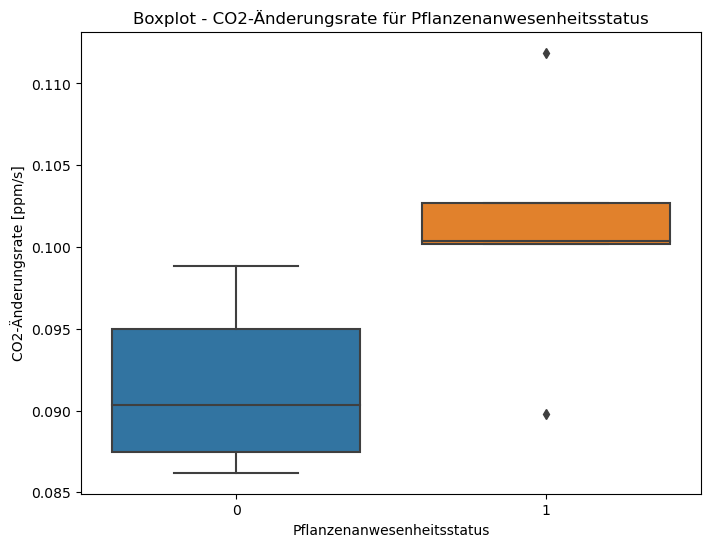

In [19]:
def filter_and_analyze_plants(data, window_status, time_difference):
    # Filtere den DataFrame für Sequenzen mit gegebenem Fensterstatus und Zeitdifferenz
    filtered_data = data[(data['Fensterstatus'] == window_status) & (data['Zeitdifferenz'] <= time_difference)]

    # Gruppiere nach Sequenz und berechne Lineare Regression für jede Sequenz
    grouped_data = filtered_data.groupby('Sequenz').apply(lambda x: linregress(x['Zeitdifferenz'], x['CO2-Wert']))

    # Extrahiere die Steigung der Linearen Regression und füge sie zum gruppierten Datensatz hinzu
    grouped_data = grouped_data.apply(lambda x: x.slope)
    grouped_data = grouped_data.to_frame(name='Steigung')

    # Füge den Pflanzenstatus und den CO2-Wert zu Beginn der Sequenz hinzu
    start_values = filtered_data.groupby('Sequenz').agg({
        'Pflanzen': 'first'
    })
    grouped_data = grouped_data.join(start_values, on='Sequenz')

    # Benenne die Spalten um
    grouped_data.columns = ['Steigung', 'Pflanzen']

    # Setze den Index zurück
    grouped_data.reset_index(inplace=True)

    # Gib den DataFrame aus
    return grouped_data
    
sequenzen_pflanzen = filter_and_analyze_plants(filtered_data, 0, 18000)
print(sequenzen_pflanzen)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Pflanzen', y='Steigung', data=sequenzen_pflanzen)
plt.xlabel('Pflanzenanwesenheitsstatus')
plt.ylabel('CO2-Änderungsrate [ppm/s]')
plt.title('Boxplot - CO2-Änderungsrate für Pflanzenanwesenheitsstatus')
plt.show()


Wie bereits bei Fragestellung 1 konnte über die CO2-Anstiege anschliessend mithilfe Linearer Regression eine Gerade darübergelegt werden, aus welcher die Steigung entnommen werden konnte. Im Boxplot wurden die CO2-Änderungsraten nach Pflanzen anwesend (1) oder nicht anwesend (0) aufgeteilt, was bereits einen deutlichen Unterschied darstellt.

In [20]:
# Daten der beiden Gruppen
gruppe0 = sequenzen_pflanzen[sequenzen_pflanzen['Pflanzen'] == 0]['Steigung']
gruppe1 = sequenzen_pflanzen[sequenzen_pflanzen['Pflanzen'] == 1]['Steigung']

# Durchführung des zweistichproben t-Tests
t_statistic, p_value = stats.ttest_ind(gruppe0, gruppe1)

# Ausgabe der Testergebnisse
print("t-Statistic:", t_statistic)
print("p-Value:", p_value)

t-Statistic: -2.6860546258306304
p-Value: 0.021177892743377533


Der zwei-Stichproben-Test diente dazu, die beiden Gruppen zu vergleichen.

Unsere Nullhypothese war, dass sich die Anstiege nicht unterscheiden. 

Mit einem t-Statistikwert von -2.6861 und einem p-Wert von 0.0211 gibt es statistisch signifikante Evidenz dafür, dass die Mittelwerte der CO2-Änderungsraten in den beiden Gruppen (Pflanzen = 0 und Pflanzen = 1) sich unterscheiden. Die Wahrscheinlichkeit, solch einen Unterschied zwischen den Mittelwerten zu beobachten, wenn die Nullhypothese (kein Unterschied) wahr wäre, beträgt nur 0.0262.

Daher können wir die Nullhypothese ablehnen und schließen, dass es einen signifikanten Unterschied in den CO2-Änderungsraten zwischen den beiden Gruppen gibt. Der Unterschied der Mittelwerte deutet darauf hin, dass der CO2-Wert Nachts mit Pflanzen im Zimmer schneller ansteigt, als wenn keine Pflanzen im Zimmer sind.

Es ist wichtig zu beachten, dass die beiden Stichproben relativ klein sind und mit weiteren Erhebungen die Schlussfolgerungen aussagekräftiger wären.

### Fragestellung 3
### Wie unterscheidet sich der Anstieg des CO2-Wertes in Abhängigkeit mit der Raumgrösse?
#### Hypothese: Der CO2-Wert steigt bedeutend langsamer an bei wachsender Raumgrösse.

{'Erhebungsort 2': 34.056, 'Erhebungsort 3': 29.927999999999997, 'Erhebungsort 5': 117.93599999999999}


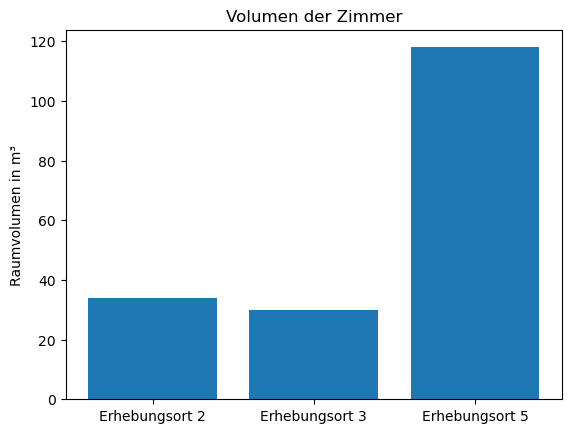

In [21]:
#Dimension für die Locations definieren
room_dimensions = {
    'Erhebungsort 2': (3.3, 4.3, 2.4),
    'Erhebungsort 3': (2.9, 4.3, 2.4),
    'Erhebungsort 5': (7.8, 6.3, 2.4)
}

#Berechnen der Volumen
room_volumes = {}
for location, dimensions in room_dimensions.items():
    length, width, height = dimensions
    volume = length * width * height
    room_volumes[location] = volume
    
print(room_volumes)

# Barplot
locations = room_volumes.keys()
volumes = room_volumes.values()

plt.bar(locations, volumes)
plt.ylabel('Raumvolumen in m³')
plt.title('Volumen der Zimmer')
plt.show()

Bei den Erhebungsorten 2 und 3 handelt es sich um Schlafzimmer und beim Erhebungsort 5 um ein Wohnzimmer, deshalb gibt es einen solch bedeutenden Unterschied

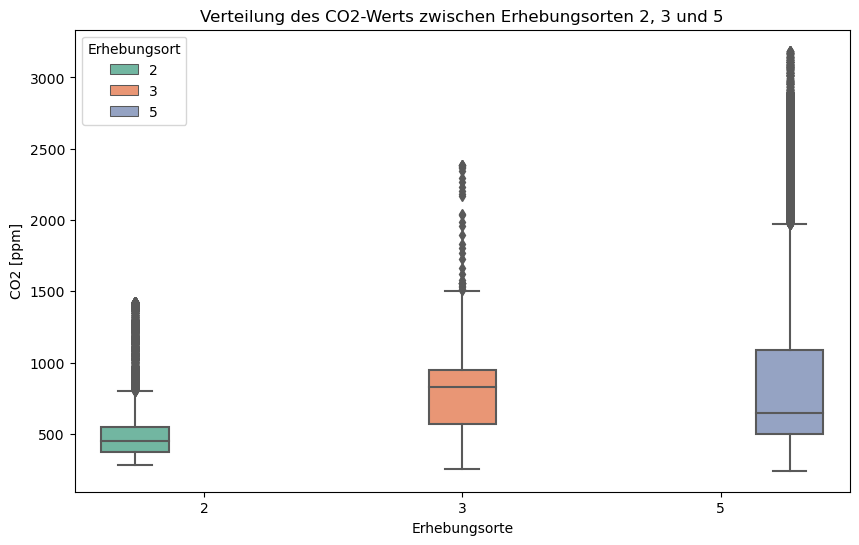

In [26]:
# Box plot für CO2-Wert
plt.figure(figsize=(10, 6))
sns.boxplot(x='Erhebungsort', y='CO2-Wert', data=pd.concat([data2_loc2, data2_loc3, data2_loc5]), hue='Erhebungsort', palette='Set2')
plt.xlabel('Erhebungsorte')
plt.ylabel('CO2 [ppm]')
plt.title('Verteilung des CO2-Werts zwischen Erhebungsorten 2, 3 und 5')
plt.show()

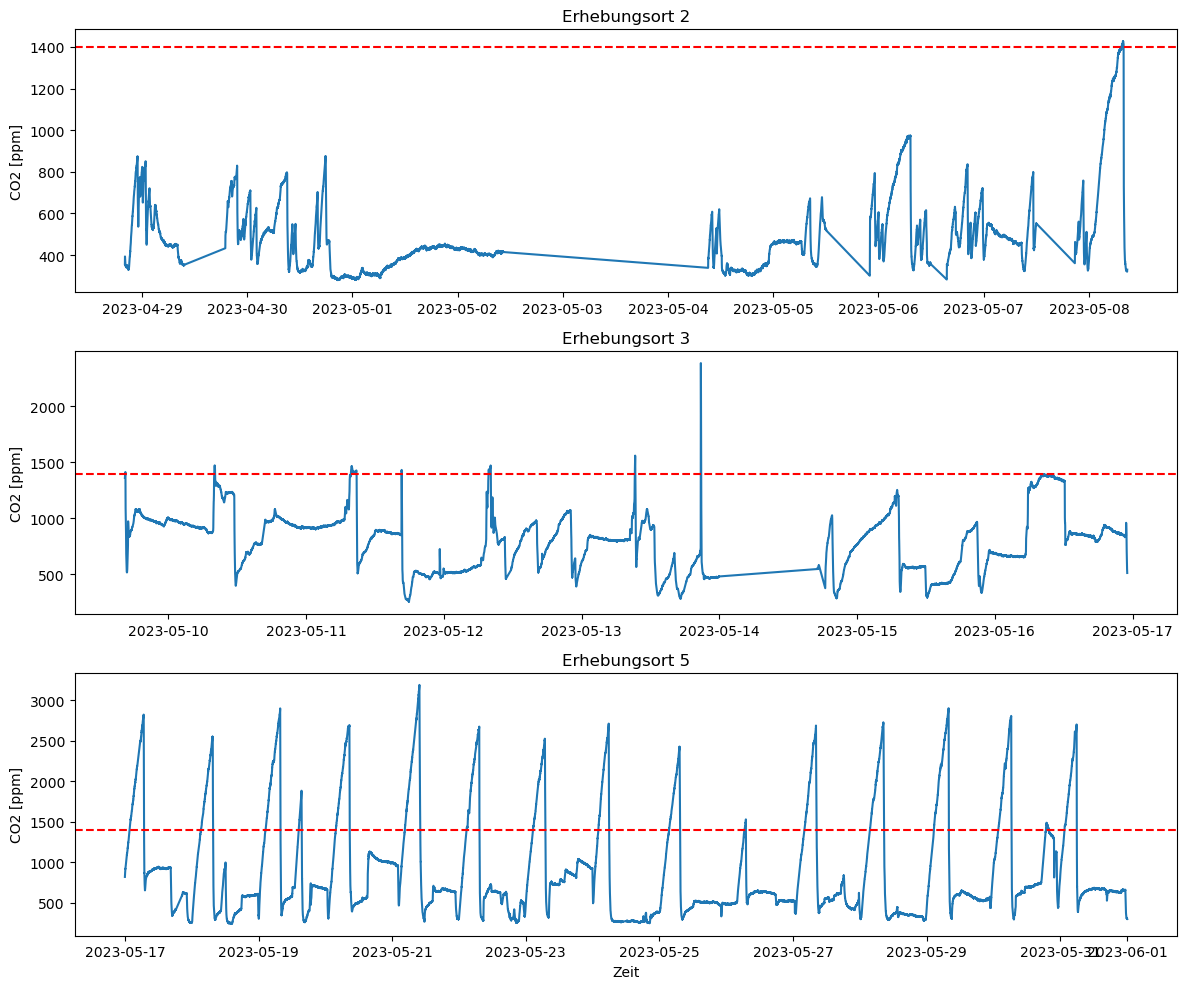

In [23]:
# Daten filtern für Location 3 und 5
data_loc3_filtered = data2_loc3[(data2_loc3['Zeit'] >= '2023-05-09') & (data2_loc3['Zeit'] <= '2023-05-17')]
data_loc5_filtered = data2_loc5[data2_loc5['Zeit'] >= '2023-05-17']

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(data2_loc2['Zeit'], data2_loc2['CO2-Wert'], label='Location 2')
axes[0].axhline(y=1400, color='red', linestyle='--')
axes[0].set_ylabel('CO2 [ppm]')
axes[0].set_title('Erhebungsort 2')

axes[1].plot(data_loc3_filtered['Zeit'], data_loc3_filtered['CO2-Wert'], label='Location 3')
axes[1].axhline(y=1400, color='red', linestyle='--')
axes[1].set_ylabel('CO2 [ppm]')
axes[1].set_title('Erhebungsort 3')

axes[2].plot(data_loc5_filtered['Zeit'], data_loc5_filtered['CO2-Wert'], label='Location 5')
axes[2].axhline(y=1400, color='red', linestyle='--')
axes[2].set_ylabel('CO2 [ppm]')
axes[2].set_xlabel('Zeit')
axes[2].set_title('Erhebungsort 5')

plt.tight_layout()
plt.show()

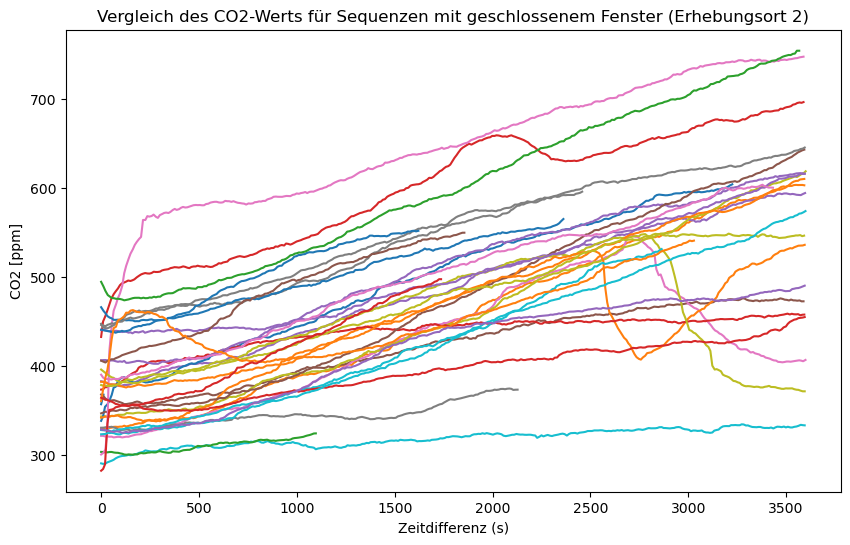

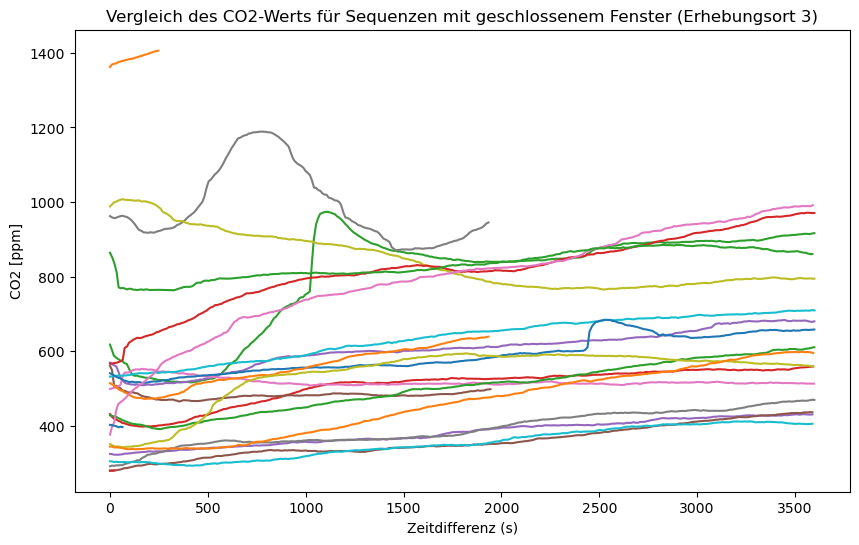

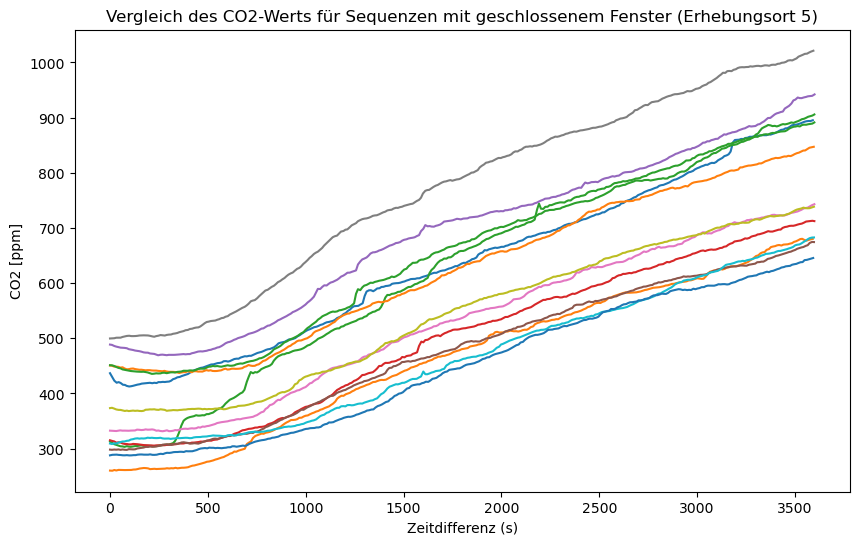

In [24]:
plot_sequences(data2_loc2, 3600, "G")
plot_sequences(data2_loc3, 3600, "G")
plot_sequences(filtered_data, 3600, "G")

Hier wird die Entwicklung des CO2-Wertes innert einer Stunde nach dem Schliessen des Fensters untersucht. Wie bereits bei den vorderen Fragestellungen konnte über die CO2-Anstiege mithilfe Linearer Regression eine Gerade darübergelegt werden, aus welcher die Steigung entnommen werden konnte

C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\janzu\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py

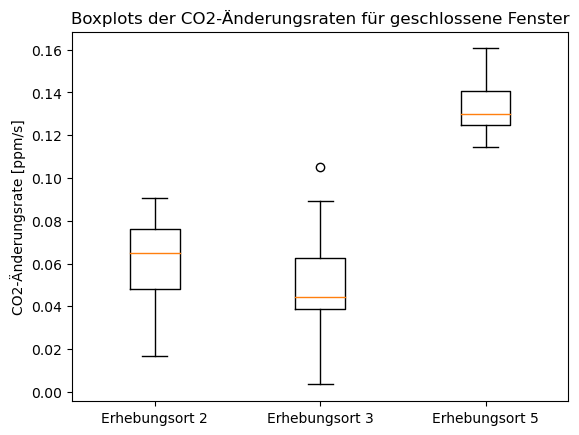

In [25]:
def filter_and_analyze_data(data, window_status, time_difference):
    # Filtere den DataFrame für Sequenzen mit gegebenem Fensterstatus und Zeitdifferenz
    filtered_data = data[(data['Fensterstatus'] == window_status) & (data['Zeitdifferenz'] <= time_difference)]

    # Gruppiere nach Sequenz und berechne Lineare Regression für jede Sequenz
    grouped_data = filtered_data.groupby('Sequenz').apply(lambda x: linregress(x['Zeitdifferenz'], x['CO2-Wert']))

    # Extrahiere die Steigung der Linearen Regression und füge sie zum gruppierten Datensatz hinzu
    grouped_data = grouped_data.apply(lambda x: x.slope)
    grouped_data = grouped_data.to_frame(name='Steigung')

    # Filtere die mittleren 90% der Steigungen und entferne negative Steigungen
    lower_bound = grouped_data['Steigung'].quantile(0.05)
    upper_bound = grouped_data['Steigung'].quantile(0.95)
    filtered_data = grouped_data[(grouped_data['Steigung'] >= lower_bound) & (grouped_data['Steigung'] <= upper_bound) & (grouped_data['Steigung'] >= 0)]

    # Benenne die Spalten um
    filtered_data.columns = ['Steigung']

    # Setze den Index zurück
    filtered_data.reset_index(inplace=True)

    # Gib den DataFrame aus
    return filtered_data

location2_closed = filter_and_analyze_data(data2_loc2, 0, 3600)
location3_closed = filter_and_analyze_data(data2_loc3, 0, 3600)
location5_closed = filter_and_analyze_data(filtered_data, 0, 3600)

# Daten für die Boxplots
data = [location2_closed['Steigung'], location3_closed['Steigung'], location5_closed['Steigung']]

# Labels für die x-Achse
labels = ['Erhebungsort 2', 'Erhebungsort 3', 'Erhebungsort 5']

# Boxplot erstellen
plt.boxplot(data, labels=labels)

# Achsentitel und Diagrammtitel hinzufügen
plt.ylabel('CO2-Änderungsrate [ppm/s]')
plt.title('Boxplots der CO2-Änderungsraten für geschlossene Fenster')

# Diagramm anzeigen
plt.show()

Da bei den Messungen auch Fehler passiert sein könnten wurden die oberen 5% und die unteren 5% der Steigungen entfernt. Da der CO2-Wert nach schliessen des Fensters nicht sinken sollte, wurden auch die negativen Werte entfernt.

Bei den Boxplots wird ersichtlich, dass der CO2-Wert in den kleineren Zimmern schneller ansteigt als im Wohnzimmer. Die vergleichsweise extermen Werte beim Erhebungsort 5 sind darauf zurückzuführen, dass es sich um ein neueres und dichteres Gebäude handelt als der gleichgrosse Raum beim Erhebungsort 2. So kommt mehr Luft dazu und der CO2-Wert kann weniger schnell ansteigen.
Unsere Hypothese, dass der CO2-Wert bei wachsender Raumgrösse deutlich schneller ansteigt, wird somit bestätigt, in dem wir den Erhebungsort 3 mit dem Erhebungsort 5 vergleichen, welche sich im selben Gebäude befinden, aber unterschiedliche Raumgrössen haben.